## Investigates the gains for different entropy-coding schemes

In [3]:
import bench_utils
from algos.alg_fpd_extended import FpdExtended
from shapely.geometry import shape
from algos.fpd_extended_lib.compress import get_zz_encoded_delta
from algos.fpd_extended_lib.decompress import decode_header
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fpde = FpdExtended()
#%pip install dill
import dill as pickle
import math
from intersection.plotting import xs, ys
import numpy as np

ENTROPY_BASE_PATH = "data/entropy_models"

In [4]:
# Load a bunch of data-sets
# chunks[delta_size] - contains a list of chunks, first indexed by the number of bits used per delta


from collections import defaultdict
from bitarray import bitarray
from algos.fpd_extended_lib import cfg
import shapely
import tqdm

shape_cnt = 0
dt_to_coord = defaultdict()
dt_freq = defaultdict(lambda: defaultdict(int))
dt_xs = []
dt_ys = []
chunks = defaultdict(list)
failed = 0

def append_deltas(dataset, is_shp_dir=False):
    global shape_cnt
    global failed
    if not is_shp_dir:
        df, idxs = bench_utils.read_dataset(dataset)
    else:
        df, idxs = bench_utils.load_shp_files(dataset)

    for idx in tqdm.tqdm(idxs):
        shape_cnt += 1
        geom = shape(df.iloc[idx]) if not is_shp_dir else df.iloc[idx].geometry
        if geom.geom_type not in ["LineString", "Polygon", "MultiPolygon"]:
            continue
        try: 
            bin = fpde.compress(geom)[1]
            cfg.offset = 0
            delta_size, type = decode_header(bin)
            chks = fpde.get_chunks(bin, include_ring_start=False)[0]
            # Go though deltas
            for chk in chks:
                chk_dts = []
                for i in range(len(chk) - 1):
                    dt_x = get_zz_encoded_delta(chk[i][0], chk[i + 1][0])
                    dt_y = get_zz_encoded_delta(chk[i][1], chk[i + 1][1])
                    dt_to_coord[dt_x] = chk[i + 1][0] - chk[i][0]
                    dt_to_coord[dt_y] = chk[i + 1][1] - chk[i][1]
                    dt_freq[delta_size][dt_x] += 1
                    dt_freq[delta_size][dt_y] += 1
                    dt_xs.append(dt_x)
                    dt_ys.append(dt_y)
                    chk_dts += [dt_x, dt_y]
                chunks[delta_size].append(chk_dts)
        except:
            print("Failed one geom!")
            #print(geom)
            #return
            failed += 1
                
GENERATE_DATA = False
SAVE_DATA = False
GENERATE_MODELS = False # Set to False to load stored models
SAVE_MODELS = False

if GENERATE_DATA:
    append_deltas("data/sweden-latest-free", is_shp_dir=True)
    append_deltas("data/lund_building_highway.json")
    append_deltas("data/world_7_dec.json")
    append_deltas("data/sweden.json")

    if SAVE_DATA:
        with open('data/delta_freqs.pkl', 'wb') as f:
            pickle.dump([shape_cnt, dt_to_coord, dt_freq, dt_xs, dt_ys, chunks], f)
    print("Failed:", failed)
else:
    with open('data/delta_freqs.pkl', 'rb') as f:
        shape_cnt, dt_to_coord, dt_freq, dt_xs, dt_ys, chunks = pickle.load(f)
    

print(f"Number of shapes: {shape_cnt}")
print(f"Number of deltas: {len(dt_xs) + len(dt_ys)}")

Number of shapes: 7283780
Number of deltas: 186669896


In [5]:
dt_freq_sorted = defaultdict(lambda: defaultdict(int))
dt_freq_sorted_key = defaultdict(lambda: defaultdict(int))
for bit_size in sorted(dt_freq.keys()):
    freqs = sorted(dt_freq[bit_size].items(), key=lambda x: -x[1])
    dt_freq_sorted[bit_size] = freqs
    dt_freq_sorted_key[bit_size] = sorted(dt_freq[bit_size].items(), key=lambda x: x[0])

DISP = 17
print(dt_freq_sorted[DISP])
print(dt_freq_sorted_key[DISP])

[(0, 18231), (4999, 5622), (5000, 5541), (9999, 4558), (10000, 4471), (15000, 2425), (14999, 2261), (20000, 2015), (19999, 2012), (10300, 1782), (6866, 1741), (3434, 1691), (858, 1687), (27466, 1681), (6865, 1666), (17166, 1603), (5150, 1600), (3004, 1546), (6008, 1543), (3433, 1506), (10299, 1484), (5149, 1474), (857, 1454), (17165, 1437), (1716, 1432), (2146, 1423), (27465, 1395), (4292, 1385), (6007, 1379), (11158, 1371), (3003, 1352), (1288, 1275), (1715, 1273), (4291, 1266), (2145, 1261), (20600, 1256), (4000, 1248), (3862, 1239), (12016, 1239), (11157, 1236), (8154, 1228), (13732, 1204), (3999, 1202), (13731, 1146), (3861, 1142), (1287, 1137), (34332, 1136), (430, 1133), (24999, 1131), (20599, 1117), (8153, 1111), (1502, 1111), (25000, 1103), (644, 1099), (4720, 1079), (13734, 1076), (2574, 1072), (9012, 1071), (7296, 1071), (9011, 1055), (34331, 1048), (24032, 1047), (12015, 1047), (16308, 1043), (9442, 1031), (2360, 1022), (7295, 1022), (6438, 1006), (3432, 987), (2573, 981), (

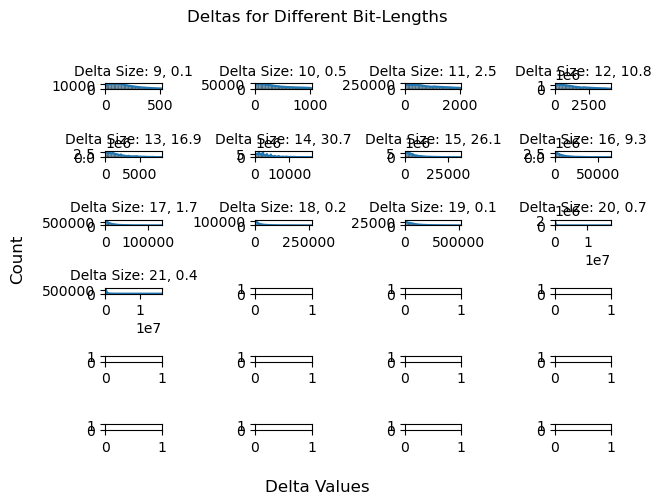

In [9]:
#sns.kdeplot()

HEIGHT = math.ceil(len(dt_freq_sorted.keys()) / 4)
WIDTH = 4

PLOT = True

if PLOT:
    tot_dts = len(dt_xs) + len(dt_ys)
    fig, axes = plt.subplots(HEIGHT, WIDTH)
    cnt_plotted = 0
    for idx, bit_size in enumerate(sorted(dt_freq.keys())):
        chks = chunks[bit_size]
        dts = [item for sublist in chks for item in sublist]
        if len(dts)/tot_dts > 0.001:
            curr_height, curr_width = cnt_plotted // WIDTH, cnt_plotted % WIDTH
            current_axis = axes[curr_height, curr_width]
            current_axis.set_title(f"Delta Size: {bit_size}, {round(100 * len(dts)/tot_dts, 1)}", fontsize=10)

            #data = list(dt_freq[bit_size].items())

            #ax = sns.kdeplot(dts, ax=current_axis)
            #ax = sns.scatterplot(x = xs(data), y=ys(data), ax=current_axis, size=0.1)
            ax = sns.histplot(dts, ax=current_axis, bins=40, kde=True)
            current_axis.set_xlim(0, max(dts))
            current_axis.set(ylabel=None)
            cnt_plotted += 1

    fig.supylabel('Count')
    fig.supxlabel('Delta Values')
    fig.suptitle('Deltas for Different Bit-Lengths', y=1.02)
    fig.set_figwidth(WIDTH * 3)
    fig.set_figheight(HEIGHT * 3)
    plt.tight_layout()
    plt.show()

In [ ]:
# for i in range(1):
#     idx = random.randint(0, len(deltas_fp))
#     print("---")
#     print("Delta in FP and LONG:    ", f'{deltas_fp[idx]:.14f}', '        ', deltas_long[idx])
#     print("Converting to f32:       ", f'{struct.unpack("!f", struct.pack("!f", deltas_fp[idx]))[0]:.14f}')
#     print("Required bits:           ", math.ceil(math.log2(deltas_long[idx] + 1)))
#     bin = util.int2ba(deltas_long[idx], length=64)
#     print("ZZ-encoded:              ", end=None)
#     util.pprint(bin, width=200)

#     bin = bitarray()
#     print("FP directly to bin:      ", end=None)
#     bin.frombytes(struct.pack("!d", deltas_fp[idx]))
#     util.pprint(bin, width=200)

#     bin = bitarray()
#     print("FP32 directly to bin:    ", end=None)
#     bin.frombytes(struct.pack("!f", deltas_fp[idx]))
    
#     util.pprint(bin, width=200)

## Calculate Entropy

In [ ]:
total_freq = defaultdict(int)

for idx, bit_size in enumerate(sorted(dt_freq.keys())):
    entropy = 0
    chks = chunks[bit_size]
    freq = dt_freq[bit_size]
    tot = sum(freq.values())
    for i in freq:
        total_freq[i] += freq[i]
        p_i = freq[i] / tot
        entropy += - p_i * np.log2(p_i)
    print(bit_size, ": Max comp factor:", entropy)
#road building, one more
entropy = 0
tot = sum(total_freq.values())
for i in total_freq:
    p_i = total_freq[i] / tot
    entropy += - p_i * np.log2(p_i)
print("TOT: Max comp factor:", entropy)

2 : Max comp factor: 1.0
3 : Max comp factor: 2.8241690761232876
4 : Max comp factor: 3.8528015921970797
5 : Max comp factor: 4.7761342341451805
6 : Max comp factor: 5.834841626385016
7 : Max comp factor: 6.763260964766167
8 : Max comp factor: 7.753372352345719
9 : Max comp factor: 8.70573018084362
10 : Max comp factor: 9.796967594601513
11 : Max comp factor: 10.81098386575361
12 : Max comp factor: 11.52658882613758
13 : Max comp factor: 12.066797312006731
14 : Max comp factor: 12.057649347412971
15 : Max comp factor: 13.129832606099459
16 : Max comp factor: 14.294805159654274
17 : Max comp factor: 15.115839471343914
18 : Max comp factor: 15.614314473377364
19 : Max comp factor: 13.26743958581936
20 : Max comp factor: 12.842860027901164
21 : Max comp factor: 13.323355505646141
22 : Max comp factor: 13.553094185715523
23 : Max comp factor: 12.6861006324161
24 : Max comp factor: 8.680618827332802
TOT: Max comp factor: 12.93601926284609


## Encoding Huffman

In [ ]:
def evaluate_encoder(setup, bit_sizes=[]):
    glob_size_coded = 0
    glob_size_normal = 0
    keys = list(filter(lambda x: x != 0, sorted(dt_freq.keys())))
    if len(bit_sizes) != 0:
        keys = list(filter(lambda x: x in bit_sizes, keys))
    for idx, bit_size in enumerate(keys):
        chks = chunks[bit_size]
        dts = [item for sublist in chks for item in sublist]
        dt_freqs = dict(dt_freq_sorted[bit_size])
        get_encoded_size = setup(dt_freqs, chks, dts, bit_size)
        
        size_coded = 0
        size_normal = 0
        for chk in tqdm.tqdm(chks):
            size_coded += get_encoded_size(chk)
            size_normal += len(chk) * bit_size

        print(f"---: {bit_size} : DELTAS {len(dts)} ({len(dts) / len(dt_xs + dt_ys)}) :---")
        print("Deltas present:", len(dt_freqs.keys()) / math.pow(2, bit_size))
        print("Enc:", size_coded)
        print("Nor:", size_normal)
        print("Percentage:", size_coded / size_normal)
        glob_size_coded += size_coded
        glob_size_normal += size_normal


    print(f"\n---: IN TOTAL :---")
    print("Enc:", glob_size_coded)
    print("Nor:", glob_size_normal)
    print("Percentage:", glob_size_coded / glob_size_normal)

In [ ]:
#%pip install dahuffman
from dahuffman import HuffmanCodec
from bitarray import util

'''
    Huffman encoding of deltas. Note that this tree does not support missing deltas, hence the implementation
    below this cell is used in FPDE.
'''
# def huff_setup(dt_freqs, chks, dts, bit_size):

#     if GENERATE_MODELS:
#         codec = util.huffman_code(dt_freqs)
#         if SAVE_MODELS:
#             with open(f'{ENTROPY_BASE_PATH}/huff_{bit_size}.pkl', 'wb') as f:
#                 pickle.dump([bit_size, codec], f)
#     else:
#         with open(f'{ENTROPY_BASE_PATH}/huff_{bit_size}.pkl', 'rb') as f:
#             _, codec = pickle.load(f)

#     def huff(chk):
#         encoded = bitarray()
#         encoded.encode(codec, chk)
#         USE_TOGGLE_BIT = False
#         if USE_TOGGLE_BIT:
#             min_size = min(len(encoded), len(chk) * bit_size)
#             size = min_size + 1
#         else:
#             size = len(encoded)
#         return size
#     return huff

# evaluate_encoder(huff_setup)

100%|██████████| 1/1 [00:00<00:00, 3688.92it/s]


---: 2 : DELTAS 2 (1.0714100360349481e-08) :---
Deltas present: 0.5
Enc: 2
Nor: 4
Percentage: 0.5


100%|██████████| 26/26 [00:00<00:00, 68242.74it/s]


---: 3 : DELTAS 708 (3.792791527563716e-06) :---
Deltas present: 1.0
Enc: 2079
Nor: 2124
Percentage: 0.9788135593220338


100%|██████████| 14/14 [00:00<00:00, 48933.55it/s]


---: 4 : DELTAS 402 (2.1535341724302454e-06) :---
Deltas present: 0.9375
Enc: 1556
Nor: 1608
Percentage: 0.9676616915422885


100%|██████████| 61/61 [00:00<00:00, 153572.96it/s]


---: 5 : DELTAS 1090 (5.839184696390466e-06) :---
Deltas present: 1.0
Enc: 5250
Nor: 5450
Percentage: 0.963302752293578


100%|██████████| 94/94 [00:00<00:00, 222622.57it/s]


---: 6 : DELTAS 2790 (1.4946170002687524e-05) :---
Deltas present: 1.0
Enc: 16382
Nor: 16740
Percentage: 0.9786140979689367


100%|██████████| 548/548 [00:00<00:00, 343158.94it/s]


---: 7 : DELTAS 13808 (7.397014888785281e-05) :---
Deltas present: 1.0
Enc: 93864
Nor: 96656
Percentage: 0.9711140539645754


100%|██████████| 2992/2992 [00:00<00:00, 433933.53it/s]


---: 8 : DELTAS 46238 (0.00024769928623091965) :---
Deltas present: 1.0
Enc: 360209
Nor: 369904
Percentage: 0.9737904969938146


100%|██████████| 14671/14671 [00:00<00:00, 522099.39it/s]


---: 9 : DELTAS 248724 (0.0013324269490137821) :---
Deltas present: 1.0
Enc: 2171861
Nor: 2238516
Percentage: 0.9702235766909864


100%|██████████| 92453/92453 [00:00<00:00, 623814.17it/s]


---: 10 : DELTAS 986438 (0.0052843978656312105) :---
Deltas present: 1.0
Enc: 9691600
Nor: 9864380
Percentage: 0.9824844541674185


100%|██████████| 548171/548171 [00:00<00:00, 710958.53it/s]


---: 11 : DELTAS 4574790 (0.024507379593761598) :---
Deltas present: 1.0
Enc: 49625589
Nor: 50322690
Percentage: 0.9861473820258814


100%|██████████| 1958601/1958601 [00:02<00:00, 656364.38it/s]


---: 12 : DELTAS 20105598 (0.1077066973884209) :---
Deltas present: 1.0
Enc: 232318062
Nor: 241267176
Percentage: 0.9629078677490717


100%|██████████| 1925065/1925065 [00:04<00:00, 445958.70it/s]


---: 13 : DELTAS 31481378 (0.1686473216870491) :---
Deltas present: 1.0
Enc: 380815616
Nor: 409257914
Percentage: 0.9305027538209072


100%|██████████| 2359579/2359579 [00:07<00:00, 313201.25it/s]


---: 14 : DELTAS 57252170 (0.3067027476138949) :---
Deltas present: 1.0
Enc: 692111247
Nor: 801530380
Percentage: 0.8634872292675918


100%|██████████| 1726389/1726389 [00:07<00:00, 231795.59it/s]


---: 15 : DELTAS 48660000 (0.26067406176730284) :---
Deltas present: 1.0
Enc: 640207775
Nor: 729900000
Percentage: 0.8771171050828881


100%|██████████| 593105/593105 [00:03<00:00, 171561.23it/s]


---: 16 : DELTAS 17269860 (0.09251550662459254) :---
Deltas present: 0.99981689453125
Enc: 247392189
Nor: 276317760
Percentage: 0.8953177276770049


100%|██████████| 110811/110811 [00:00<00:00, 143747.98it/s]


---: 17 : DELTAS 3127174 (0.016752428040137764) :---
Deltas present: 0.8783111572265625
Enc: 47362061
Nor: 53161958
Percentage: 0.8909013659730141


100%|██████████| 17829/17829 [00:00<00:00, 123505.52it/s]


---: 18 : DELTAS 456188 (0.0024438220075935543) :---
Deltas present: 0.3952484130859375
Enc: 7135238
Nor: 8211384
Percentage: 0.8689446261434126


100%|██████████| 8554/8554 [00:00<00:00, 216277.61it/s]


---: 19 : DELTAS 199118 (0.0010666851177760339) :---
Deltas present: 0.09885787963867188
Enc: 2649494
Nor: 3783242
Percentage: 0.7003236906335889


100%|██████████| 52791/52791 [00:00<00:00, 176264.90it/s]


---: 20 : DELTAS 1353652 (0.007251581690493897) :---
Deltas present: 0.08215713500976562
Enc: 17425332
Nor: 27073040
Percentage: 0.6436414972238064


100%|██████████| 27316/27316 [00:00<00:00, 201123.14it/s]


---: 21 : DELTAS 730300 (0.003912253746581613) :---
Deltas present: 0.02994537353515625
Enc: 9753640
Nor: 15336300
Percentage: 0.6359839074613824


100%|██████████| 6354/6354 [00:00<00:00, 280556.34it/s]


---: 22 : DELTAS 135286 (0.0007247338906751199) :---
Deltas present: 0.007027864456176758
Enc: 1837173
Nor: 2976292
Percentage: 0.6172690717174256


100%|██████████| 721/721 [00:00<00:00, 203109.22it/s]


---: 23 : DELTAS 22982 (0.00012311572724077588) :---
Deltas present: 0.0013194084167480469
Enc: 292862
Nor: 528586
Percentage: 0.5540479694884087


100%|██████████| 25/25 [00:00<00:00, 57080.89it/s]


---: 24 : DELTAS 1200 (6.428460216209688e-06) :---
Deltas present: 4.589557647705078e-05
Enc: 10470
Nor: 28800
Percentage: 0.36354166666666665

---: IN TOTAL :---
Enc: 2341279551
Nor: 2632290904
Percentage: 0.8894455956377076


# Huffman for common values, else encode whole delta

In [ ]:
#%pip install dahuffman
from dahuffman import HuffmanCodec
from bitarray import util

def huff_setup(dt_freqs, chks, dts, bit_size):

    if GENERATE_MODELS:
        N = len(dt_freqs.keys())
        dt_freqs_stripped = dict(filter(lambda x: x[1] > 3, dt_freqs.items()))
        # Append outlier symbol
        sum_values = sum(list(dt_freqs_stripped.values()))
        dt_freqs_stripped[-1] = sum_values * (1 - len(dt_freqs_stripped) / N) # Estimate probablity based on outliers above
        codec = util.huffman_code(dt_freqs_stripped)
        if SAVE_MODELS:
            with open(f'{ENTROPY_BASE_PATH}/huff_{bit_size}.pkl', 'wb') as f:
                pickle.dump([bit_size, codec], f)
    else:
        with open(f'{ENTROPY_BASE_PATH}/huff_{bit_size}.pkl', 'rb') as f:
            _, codec = pickle.load(f)

    def huff(chk):
        encoded = bitarray()
        chk_valid = [x if x in codec.keys() else -1 for x in chk]
        outliers = chk_valid.count(-1)
        encoded.encode(codec, chk_valid)
        size = len(encoded)
        return size + outliers * bit_size
    return huff

evaluate_encoder(huff_setup, bit_sizes=[])

100%|██████████| 1/1 [00:00<00:00, 5262.61it/s]


---: 2 : DELTAS 2 (1.0714100360349481e-08) :---
Deltas present: 0.5
Enc: 6
Nor: 4
Percentage: 1.5


100%|██████████| 26/26 [00:00<00:00, 120900.12it/s]


---: 3 : DELTAS 708 (3.792791527563716e-06) :---
Deltas present: 1.0
Enc: 2085
Nor: 2124
Percentage: 0.981638418079096


100%|██████████| 14/14 [00:00<00:00, 44183.79it/s]


---: 4 : DELTAS 402 (2.1535341724302454e-06) :---
Deltas present: 0.9375
Enc: 1568
Nor: 1608
Percentage: 0.9751243781094527


100%|██████████| 61/61 [00:00<00:00, 127862.34it/s]


---: 5 : DELTAS 1090 (5.839184696390466e-06) :---
Deltas present: 1.0
Enc: 5258
Nor: 5450
Percentage: 0.9647706422018348


100%|██████████| 94/94 [00:00<00:00, 108912.87it/s]


---: 6 : DELTAS 2790 (1.4946170002687524e-05) :---
Deltas present: 1.0
Enc: 16389
Nor: 16740
Percentage: 0.9790322580645161


100%|██████████| 548/548 [00:00<00:00, 145666.94it/s]


---: 7 : DELTAS 13808 (7.397014888785281e-05) :---
Deltas present: 1.0
Enc: 93869
Nor: 96656
Percentage: 0.9711657838106273


100%|██████████| 2992/2992 [00:00<00:00, 213948.40it/s]


---: 8 : DELTAS 46238 (0.00024769928623091965) :---
Deltas present: 1.0
Enc: 360226
Nor: 369904
Percentage: 0.9738364548639648


100%|██████████| 14671/14671 [00:00<00:00, 215524.56it/s]


---: 9 : DELTAS 248724 (0.0013324269490137821) :---
Deltas present: 1.0
Enc: 2171935
Nor: 2238516
Percentage: 0.970256634305942


100%|██████████| 92453/92453 [00:00<00:00, 291955.36it/s]


---: 10 : DELTAS 986438 (0.0052843978656312105) :---
Deltas present: 1.0
Enc: 9691861
Nor: 9864380
Percentage: 0.982510913002135


100%|██████████| 548171/548171 [00:01<00:00, 364686.88it/s]


---: 11 : DELTAS 4574790 (0.024507379593761598) :---
Deltas present: 1.0
Enc: 49626167
Nor: 50322690
Percentage: 0.9861588678983576


100%|██████████| 1958601/1958601 [00:06<00:00, 314538.74it/s]


---: 12 : DELTAS 20105598 (0.1077066973884209) :---
Deltas present: 1.0
Enc: 232318552
Nor: 241267176
Percentage: 0.9629098986925598


100%|██████████| 1925065/1925065 [00:08<00:00, 216160.29it/s]


---: 13 : DELTAS 31481378 (0.1686473216870491) :---
Deltas present: 1.0
Enc: 380815783
Nor: 409257914
Percentage: 0.9305031618765471


100%|██████████| 2359579/2359579 [00:15<00:00, 149573.22it/s]


---: 14 : DELTAS 57252170 (0.3067027476138949) :---
Deltas present: 1.0
Enc: 692111324
Nor: 801530380
Percentage: 0.8634873253338196


100%|██████████| 1726389/1726389 [00:15<00:00, 114041.00it/s]


---: 15 : DELTAS 48660000 (0.26067406176730284) :---
Deltas present: 1.0
Enc: 640207796
Nor: 729900000
Percentage: 0.8771171338539526


100%|██████████| 593105/593105 [00:06<00:00, 91044.32it/s] 


---: 16 : DELTAS 17269860 (0.09251550662459254) :---
Deltas present: 0.99981689453125
Enc: 247585703
Nor: 276317760
Percentage: 0.896018059063594


100%|██████████| 110811/110811 [00:01<00:00, 82336.25it/s]


---: 17 : DELTAS 3127174 (0.016752428040137764) :---
Deltas present: 0.8783111572265625
Enc: 48402873
Nor: 53161958
Percentage: 0.9104795011500517


100%|██████████| 17829/17829 [00:00<00:00, 99415.11it/s] 


---: 18 : DELTAS 456188 (0.0024438220075935543) :---
Deltas present: 0.3952484130859375
Enc: 7447349
Nor: 8211384
Percentage: 0.9069541748382489


100%|██████████| 8554/8554 [00:00<00:00, 158784.17it/s]


---: 19 : DELTAS 199118 (0.0010666851177760339) :---
Deltas present: 0.09885787963867188
Enc: 2889888
Nor: 3783242
Percentage: 0.7638654889113623


100%|██████████| 52791/52791 [00:00<00:00, 125018.99it/s]


---: 20 : DELTAS 1353652 (0.007251581690493897) :---
Deltas present: 0.08215713500976562
Enc: 18656109
Nor: 27073040
Percentage: 0.6891028491813258


100%|██████████| 27316/27316 [00:00<00:00, 124604.92it/s]


---: 21 : DELTAS 730300 (0.003912253746581613) :---
Deltas present: 0.02994537353515625
Enc: 10512047
Nor: 15336300
Percentage: 0.6854356657081565


100%|██████████| 6354/6354 [00:00<00:00, 150120.59it/s]


---: 22 : DELTAS 135286 (0.0007247338906751199) :---
Deltas present: 0.007027864456176758
Enc: 2104903
Nor: 2976292
Percentage: 0.7072232831993635


100%|██████████| 721/721 [00:00<00:00, 120304.46it/s]


---: 23 : DELTAS 22982 (0.00012311572724077588) :---
Deltas present: 0.0013194084167480469
Enc: 421156
Nor: 528586
Percentage: 0.7967596568959451


100%|██████████| 25/25 [00:00<00:00, 71820.27it/s]


---: 24 : DELTAS 1200 (6.428460216209688e-06) :---
Deltas present: 4.589557647705078e-05
Enc: 22839
Nor: 28800
Percentage: 0.7930208333333333

---: IN TOTAL :---
Enc: 2345465686
Nor: 2632290904
Percentage: 0.8910358966920626


In [ ]:
#%pip install golomb_coding
from golomb_coding import golomb_coding, optimal_golomb_coding
from bitarray import util

golomb_param = {}

def golomb_setup(dt_freqs, chks, dts, bit_size):
    delta_mean = sum(dts) / len(dts)
    golden_ratio = (math.sqrt(5) + 1) / 2
    param = max(0, 1 + math.floor(math.log2(math.log(golden_ratio - 1) / math.log(delta_mean / (delta_mean + 1)))))
    param = int(math.pow(2, param))
    golomb_param[bit_size] = param
    tot = sum(dt_freqs.values())
    def golomb(chk):
        encoded = [golomb_coding(d, param) for d in chk]
        #encoded = [optimal_golomb_coding(d, dt_freqs[d] / tot) for d in chk]
        return sum(list(map(lambda x: len(x), encoded)))
    return golomb

evaluate_encoder(golomb_setup, bit_sizes=[])

100%|██████████| 1/1 [00:00<00:00, 2786.91it/s]


---: 2 : DELTAS 2 (1.0714100360349481e-08) :---
Deltas present: 0.5
Enc: 5
Nor: 4
Percentage: 1.25


100%|██████████| 26/26 [00:00<00:00, 8935.02it/s]


---: 3 : DELTAS 708 (3.792791527563716e-06) :---
Deltas present: 1.0
Enc: 2236
Nor: 2124
Percentage: 1.0527306967984935


100%|██████████| 14/14 [00:00<00:00, 7279.97it/s]


---: 4 : DELTAS 402 (2.1535341724302454e-06) :---
Deltas present: 0.9375
Enc: 1743
Nor: 1608
Percentage: 1.083955223880597


100%|██████████| 61/61 [00:00<00:00, 16154.35it/s]


---: 5 : DELTAS 1090 (5.839184696390466e-06) :---
Deltas present: 1.0
Enc: 5516
Nor: 5450
Percentage: 1.0121100917431192


100%|██████████| 94/94 [00:00<00:00, 10944.19it/s]


---: 6 : DELTAS 2790 (1.4946170002687524e-05) :---
Deltas present: 1.0
Enc: 16945
Nor: 16740
Percentage: 1.0122461170848267


100%|██████████| 548/548 [00:00<00:00, 11340.32it/s]


---: 7 : DELTAS 13808 (7.397014888785281e-05) :---
Deltas present: 1.0
Enc: 96925
Nor: 96656
Percentage: 1.0027830657175965


100%|██████████| 2992/2992 [00:00<00:00, 21549.51it/s]


---: 8 : DELTAS 46238 (0.00024769928623091965) :---
Deltas present: 1.0
Enc: 371124
Nor: 369904
Percentage: 1.0032981530343008


100%|██████████| 14671/14671 [00:00<00:00, 20695.62it/s]


---: 9 : DELTAS 248724 (0.0013324269490137821) :---
Deltas present: 1.0
Enc: 2202940
Nor: 2238516
Percentage: 0.9841073282478213


100%|██████████| 92453/92453 [00:02<00:00, 35863.77it/s]


---: 10 : DELTAS 986438 (0.0052843978656312105) :---
Deltas present: 1.0
Enc: 9835493
Nor: 9864380
Percentage: 0.9970715848335121


100%|██████████| 548171/548171 [00:13<00:00, 40499.43it/s]


---: 11 : DELTAS 4574790 (0.024507379593761598) :---
Deltas present: 1.0
Enc: 50587334
Nor: 50322690
Percentage: 1.0052589398539704


100%|██████████| 1958601/1958601 [00:59<00:00, 33049.49it/s]


---: 12 : DELTAS 20105598 (0.1077066973884209) :---
Deltas present: 1.0
Enc: 237063273
Nor: 241267176
Percentage: 0.9825757358721685


100%|██████████| 1925065/1925065 [01:39<00:00, 19371.81it/s]


---: 13 : DELTAS 31481378 (0.1686473216870491) :---
Deltas present: 1.0
Enc: 392581627
Nor: 409257914
Percentage: 0.9592523774628827


100%|██████████| 2359579/2359579 [02:57<00:00, 13290.27it/s]


---: 14 : DELTAS 57252170 (0.3067027476138949) :---
Deltas present: 1.0
Enc: 757302249
Nor: 801530380
Percentage: 0.944820393457825


 14%|█▍        | 246051/1726389 [00:23<02:19, 10611.07it/s]


KeyboardInterrupt: 

In [ ]:
#inverted_unary(n // b)+minimal_binary_coding(n % b, b)

from minimal_binary_coding import minimal_binary_coding
from unary_coding import inverted_unary


def golomb_huff_setup(dt_freqs, chks, dts, bit_size):
    delta_mean = sum(dts) / len(dts)
    golden_ratio = (math.sqrt(5) + 1) / 2
    param = max(0, 1 + math.floor(math.log2(math.log(golden_ratio - 1) / math.log(delta_mean / (delta_mean + 1)))))
    param = int(math.pow(2, param))
    k_freqs = defaultdict(int)

    #k_freq_dist = []
    for d, cnt in dt_freqs.items():
        k = inverted_unary(d // param)
        k_freqs[k] += cnt
        #k_freq_dist += [k for _ in range(cnt)]
    
    #sns.histplot(k_freq_dist, bins=40)
    k_codec = util.huffman_code(k_freqs)

    def golomb_huff(chk):
        enc_len = 0
        for d in chk:
            k = inverted_unary(d // param)
            r = minimal_binary_coding(d % param, param)
            enc_len += len(k_codec[k].to01()) + len(r)

        return enc_len
    return golomb_huff

evaluate_encoder(golomb_huff_setup, bit_sizes=[])

100%|██████████| 1/1 [00:00<00:00, 3057.07it/s]


---: 15 : DELTAS 10 (4.190468527905168e-06) :---
Deltas present: 1.0
Enc: 148
Nor: 150
Percentage: 0.9866666666666667


100%|██████████| 195/195 [00:00<00:00, 26153.21it/s]


---: 17 : DELTAS 2388 (0.0010006838844637542) :---
Deltas present: 0.8783111572265625
Enc: 39670
Nor: 40596
Percentage: 0.9771898709232437


100%|██████████| 759/759 [00:00<00:00, 13801.06it/s]


---: 18 : DELTAS 19326 (0.008098499477029527) :---
Deltas present: 0.3952484130859375
Enc: 333883
Nor: 347868
Percentage: 0.959797969344694


100%|██████████| 5811/5811 [00:00<00:00, 19343.18it/s]


---: 19 : DELTAS 132982 (0.05572568857778851) :---
Deltas present: 0.09885787963867188
Enc: 2415521
Nor: 2526658
Percentage: 0.9560142290725535


100%|██████████| 52365/52365 [00:02<00:00, 18941.93it/s]


---: 20 : DELTAS 1344136 (0.5632559605224341) :---
Deltas present: 0.08215713500976562
Enc: 25700446
Nor: 26882720
Percentage: 0.9560210425135551


100%|██████████| 27239/27239 [00:01<00:00, 19048.34it/s]


---: 21 : DELTAS 728586 (0.3053116702872315) :---
Deltas present: 0.02994537353515625
Enc: 14445375
Nor: 15300306
Percentage: 0.9441232743972572


100%|██████████| 6331/6331 [00:00<00:00, 19230.42it/s]


---: 22 : DELTAS 134758 (0.05646991578834446) :---
Deltas present: 0.007027864456176758
Enc: 2792653
Nor: 2964676
Percentage: 0.9419757842003645


100%|██████████| 721/721 [00:00<00:00, 10480.89it/s]


---: 23 : DELTAS 22982 (0.009630534770831657) :---
Deltas present: 0.0013194084167480469
Enc: 484313
Nor: 528586
Percentage: 0.9162425792586258


100%|██████████| 25/25 [00:00<00:00, 5426.57it/s]

---: 24 : DELTAS 1200 (0.0005028562233486202) :---
Deltas present: 4.589557647705078e-05
Enc: 27369
Nor: 28800
Percentage: 0.9503125

---: IN TOTAL :---
Enc: 46239378
Nor: 48620360
Percentage: 0.9510291161974119


In [ ]:
from bitarray import bitarray, util

def fpzip_setup(dt_freqs, chks, dts, bit_size):
    k_freqs = defaultdict(int)
    r_freqs = defaultdict(int)
    for d, cnt in dt_freqs.items():
        k = int(math.floor(np.log2(d))) if d != 0 else -1
        k_freqs[k] += cnt
        #if k != -1:
            #r = d - int(math.pow(2, k))
            #r_freqs[r] += 1
    #k_codec = HuffmanCodec.from_frequencies(k_freqs)
    #r_codec = HuffmanCodec.from_frequencies(r_freqs)
    k_codec = util.huffman_code(k_freqs)
    #r_codec = util.huffman_code(r_freqs)

    def fpzip(chk):
        size = 0
        for d in chk:
            k = int(math.floor(np.log2(d))) if d != 0 else -1
            r = d - int(math.pow(2, k))
            #size += len(k_codec.encode([k])) + (len(r_codec.encode([r])) if k != -1 else 0)
            #size += len(k_codec[k].to01()) + (len(r_codec[r].to01()) if k != -1 else 0)
            size += len(k_codec[k].to01()) + k if k != -1 else 0
        return size 
    return fpzip

evaluate_encoder(fpzip_setup)

100%|██████████| 1/1 [00:00<00:00, 2898.62it/s]


---: 2 : DELTAS 2 (1.0714100360349481e-08) :---
Deltas present: 0.5
Enc: 2
Nor: 4
Percentage: 0.5


100%|██████████| 26/26 [00:00<00:00, 9039.45it/s]


---: 3 : DELTAS 708 (3.792791527563716e-06) :---
Deltas present: 1.0
Enc: 1821
Nor: 2124
Percentage: 0.8573446327683616


100%|██████████| 14/14 [00:00<00:00, 6563.12it/s]


---: 4 : DELTAS 402 (2.1535341724302454e-06) :---
Deltas present: 0.9375
Enc: 1496
Nor: 1608
Percentage: 0.9303482587064676


100%|██████████| 61/61 [00:00<00:00, 13448.23it/s]


---: 5 : DELTAS 1090 (5.839184696390466e-06) :---
Deltas present: 1.0
Enc: 5174
Nor: 5450
Percentage: 0.9493577981651377


100%|██████████| 94/94 [00:00<00:00, 7431.52it/s]


---: 6 : DELTAS 2790 (1.4946170002687524e-05) :---
Deltas present: 1.0
Enc: 16209
Nor: 16740
Percentage: 0.9682795698924731


100%|██████████| 548/548 [00:00<00:00, 7922.65it/s]


---: 7 : DELTAS 13808 (7.397014888785281e-05) :---
Deltas present: 1.0
Enc: 93993
Nor: 96656
Percentage: 0.9724486839927164


100%|██████████| 2992/2992 [00:00<00:00, 14814.16it/s]


---: 8 : DELTAS 46238 (0.00024769928623091965) :---
Deltas present: 1.0
Enc: 360528
Nor: 369904
Percentage: 0.9746528829101605


100%|██████████| 14671/14671 [00:01<00:00, 13938.03it/s]


---: 9 : DELTAS 248724 (0.0013324269490137821) :---
Deltas present: 1.0
Enc: 2167105
Nor: 2238516
Percentage: 0.968098954843298


100%|██████████| 92453/92453 [00:04<00:00, 22073.85it/s]


---: 10 : DELTAS 986438 (0.0052843978656312105) :---
Deltas present: 1.0
Enc: 9657006
Nor: 9864380
Percentage: 0.9789774927567673


100%|██████████| 548171/548171 [00:22<00:00, 24109.16it/s]


---: 11 : DELTAS 4574790 (0.024507379593761598) :---
Deltas present: 1.0
Enc: 49688857
Nor: 50322690
Percentage: 0.9874046280117379


  1%|          | 11770/1958601 [00:01<04:54, 6615.31it/s]


KeyboardInterrupt: 